In [258]:
%load_ext autoreload
%autoreload 2

from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from copy import deepcopy
from tqdm import tqdm
import importlib
from helpers import NormalizedEnv

from heuristicpolicy import HeuristicPendulumAgent
from qnetwork import QNetwork
from policynetwork import PolicyNetwork
from gaussian_action_noise import GaussianActionNoise
from ddpg_agent import DDPGAgent
from replaybuffer import ReplayBuffer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:


#Create random agent
# random_agent = RandomAgent(pendulum)
# heuristic_agent = HeuristicPendulumAgent(pendulum)

In [259]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [260]:
MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99
NOISE_STD = 0.3

In [261]:
torch.manual_seed(-1)

#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

noise = GaussianActionNoise(NOISE_STD)

critic  = QNetwork().to(device) # critic
actor = PolicyNetwork().to(device) # policy_network

memory = ReplayBuffer(max_size=BUFFER_SIZE)

In [262]:
agent = DDPGAgent(actor, noise)

In [263]:

q_optimizer  = optim.Adam(critic.parameters(),  lr=LEARNING_RATE)
policy_optimizer  = optim.Adam(actor.parameters(),  lr=LEARNING_RATE)

MSE = nn.MSELoss()

In [309]:
state = torch.FloatTensor(state_batch).to(device)
action = torch.FloatTensor([action_batch]).to(device)
reward = torch.FloatTensor(reward_batch).unsqueeze(1).to(device) #.unsqueeze(1)
trunc = torch.Tensor([np.float32(trunc_batch)]).unsqueeze(1).to(device)
next_state = torch.FloatTensor(next_state_batch).to(device)


In [310]:
# TODO: is it False??
action_next_state = agent.compute_action(state = next_state, deterministic=True) # np

# To compute the targets in each step, do not use the on-trajectory action, 
# but compute a new action according to the policy
network_input_state = torch.cat((state, action.T),1)


In [312]:
action_next_state.shape

torch.Size([128, 1])

In [314]:
next_state.shape

torch.Size([128, 3])

In [322]:
def onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, agent, gamma, critic, iter):

    targets = []
    q_state = []

    state = torch.FloatTensor(state_batch).to(device)
    action = torch.FloatTensor([action_batch]).to(device)
    reward = torch.FloatTensor(reward_batch).unsqueeze(1).to(device) #.unsqueeze(1)
    trunc = torch.Tensor([np.float32(trunc_batch)]).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state_batch).to(device)
    
    action_next_state = agent.compute_action(state = next_state) # np

    # To compute the targets in each step, do not use the on-trajectory action, 
    # but compute a new action according to the policy
    network_input_state = torch.cat((state, action.T),1)

    network_input_next_state = torch.cat((next_state, action_next_state),1)
    with torch.no_grad():
        # network_input_next_state or network_input_state
        q_next = critic(network_input_next_state) # should not be differentiated 

    q_state.append([q_next]) # no grad??
    if iter == MAX_IT:
        q_next = 0
    target_state = reward + gamma * q_next # the last update in each episode should use q = 0 ?
    targets.append(target_state)

    q = critic(network_input_state)
    #q_state.append(q)

    q_optimizer.zero_grad()
    q_loss = MSE(target_state, q)
    q_loss.backward()
    q_optimizer.step()

    return q_loss


In [323]:
def test_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, actor, critic):

    targets = []
    q_state = []

    state = torch.FloatTensor(state_batch).to(device)
    action = torch.FloatTensor(np.array([action_batch])).to(device)
    reward = torch.FloatTensor(reward_batch).unsqueeze(1).to(device) #.unsqueeze(1)
    trunc = torch.Tensor(np.array([np.float32(trunc_batch)])).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state_batch).to(device)

    network_input_state = torch.cat((state, action.T),1)

    #compute loss for actor
    
    # N.B.: do not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # you have to compute them with the current actor - DDPG is an off-policy algorithm
    network_input_state = torch.cat((state, actor(state)), 1)
    with torch.no_grad():
        policy_loss = -critic(network_input_state)
        policy_loss = policy_loss.mean()
    
    
    return policy_loss

In [324]:
def learning_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, actor, critic):

    targets = []
    q_state = []

    state = torch.FloatTensor(state_batch).to(device)
    action = torch.FloatTensor(np.array([action_batch])).to(device)
    reward = torch.FloatTensor(reward_batch).unsqueeze(1).to(device) #.unsqueeze(1)
    trunc = torch.Tensor(np.array([np.float32(trunc_batch)])).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state_batch).to(device)

    network_input_state = torch.cat((state, action.T),1)

    #compute loss for actor
    policy_optimizer.zero_grad()
    # N.B.: do not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # you have to compute them with the current actor - DDPG is an off-policy algorithm
    network_input_state = torch.cat((state, actor(state)), 1)
    policy_loss = -critic(network_input_state)
    policy_loss = policy_loss.mean()
    policy_loss.backward()
    policy_optimizer.step()
    
    return policy_loss

In [325]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
nr_of_samples = 128


In [326]:
q_losses = []
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        # how many iterations??
        #TODO: False ??
        action = agent.compute_action(state = current_state, deterministic=False)
        #transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        
        # TODO: buffer_start = ??
        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            # TODO: sample random from 0 to 200??
            #indices = np.random.randint(0, 200, nr_of_samples)
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # 1-step TD-learning rule
            q_loss = onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, agent, GAMMA, critic, i)

            #TODO:  
            policy_loss = learning_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, actor, critic)
                       
        
        current_state = deepcopy(next_state)
        ep_reward += reward
    # plot_q.append([loss, episode])
    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.data, episode+1])
        plot_q.append([q_loss.data, episode+1])
        plot_steps.append([step+1, episode+1])
        # q_losses.append(q_loss.item())

        if (episode % 100 == 0):
            print(policy_loss.item())
    except:
        continue
    average_reward += ep_reward


  0%|          | 1/1000 [00:02<34:01,  2.04s/it]

1.1488213539123535


 10%|█         | 101/1000 [05:53<1:05:04,  4.34s/it]

533.371337890625


 20%|██        | 201/1000 [13:18<1:00:57,  4.58s/it]

619.436767578125


 30%|███       | 301/1000 [20:53<55:09,  4.73s/it]  

643.7285766601562


 40%|████      | 401/1000 [32:28<22:06,  2.21s/it]   

742.39794921875


 50%|█████     | 501/1000 [38:30<19:30,  2.35s/it]

764.495849609375


 60%|██████    | 601/1000 [42:25<14:36,  2.20s/it]

731.1939697265625


 70%|███████   | 701/1000 [46:02<10:42,  2.15s/it]

752.256103515625


 80%|████████  | 801/1000 [1:31:10<07:12,  2.18s/it]    

784.1072998046875


 90%|█████████ | 901/1000 [1:34:52<03:34,  2.17s/it]

752.4473266601562


100%|██████████| 1000/1000 [1:40:01<00:00,  6.00s/it]


In [329]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')

    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    
    ax[1, 1].title.set_text('Max steps')
    plt.show()

IndexError: list index out of range

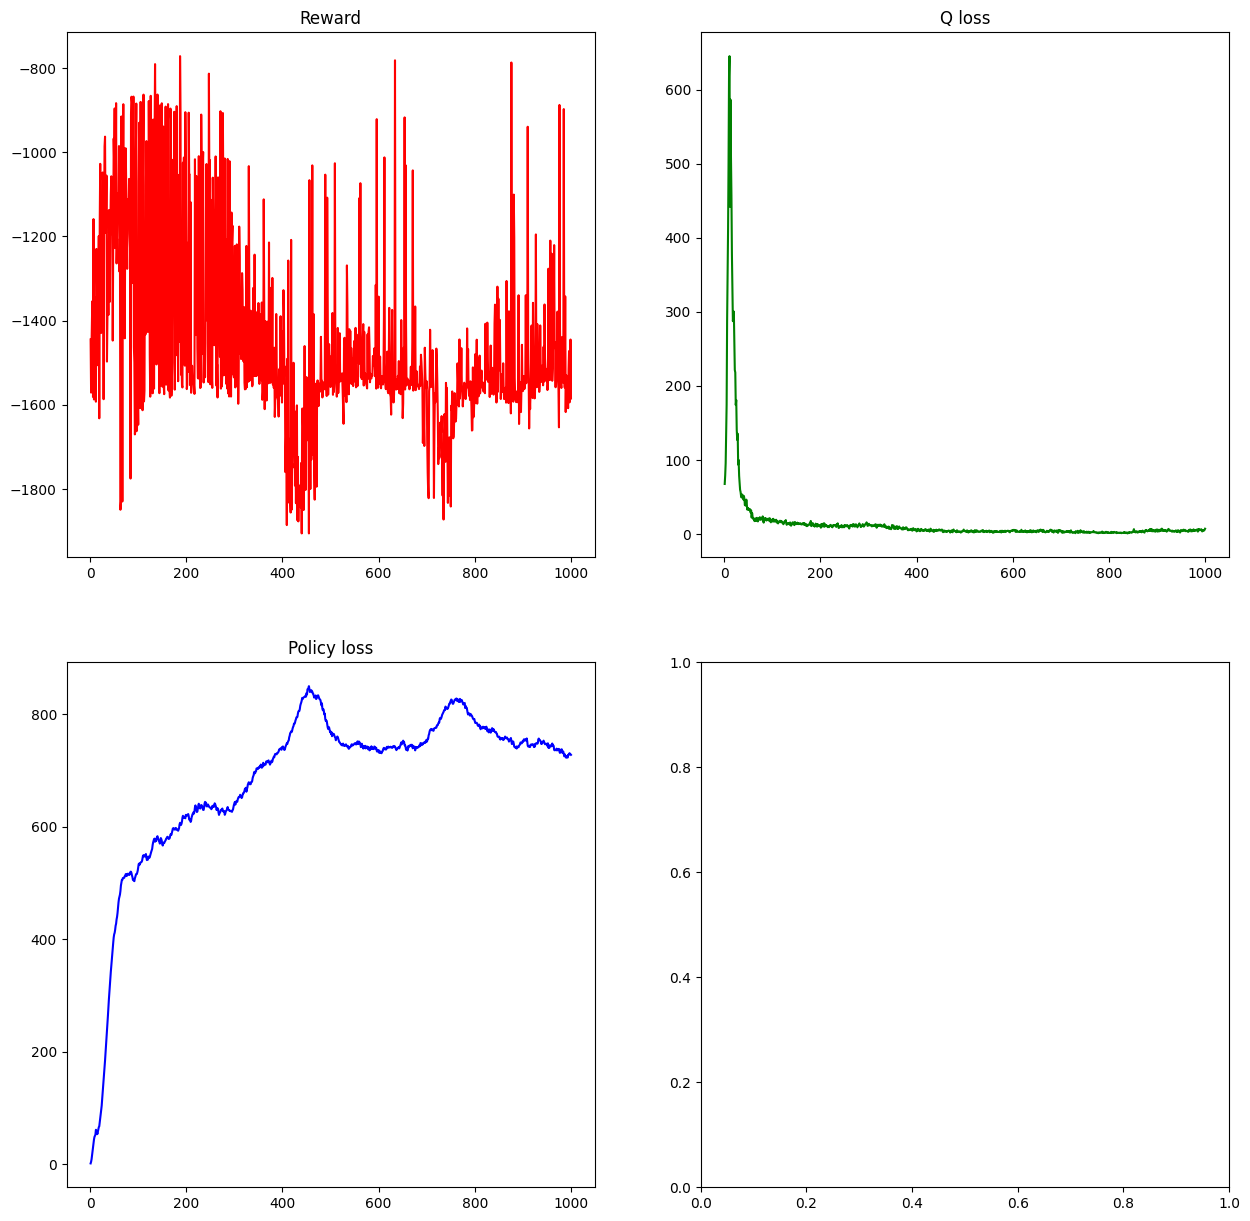

In [330]:
subplot(plot_reward, plot_policy, plot_q, plot_steps)

Text(0.5, 1.0, 'Policy loss')

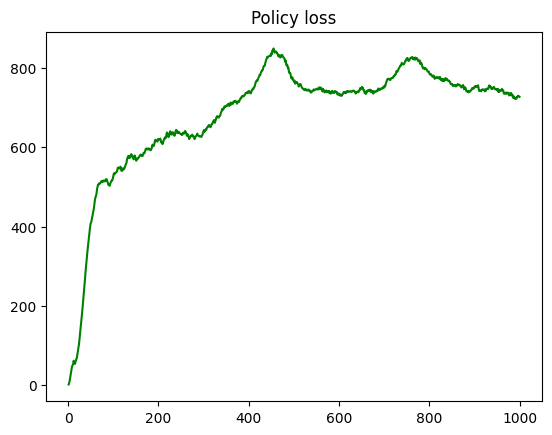

In [331]:
q = list(zip(*plot_policy))
plt.plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
plt.title('Policy loss')

In [ ]:
cumulative_reward = 0
for episode in tqdm(range(100)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        # how many iterations??
        action = agent.compute_action(state = current_state)
        # transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        
        # TODO: buffer_start = ??
        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            # TODO: sample random from 0 to 200??
            #indices = np.random.randint(0, 200, nr_of_samples)
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # 1-step TD-learning rule
            #TODO: the last update in each episode should use q = 0 !!
            policy_loss = test_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, network)
                       
        
        current_state = deepcopy(next_state)
        cumulative_reward += reward
    # plot_q.append([loss, episode])
    try:
        # plot_reward.append([ep_reward, episode+1])
        # plot_policy.append([policy_loss.data, episode+1])
        # plot_q.append([q_loss.data, episode+1])
        # q_losses.append(q_loss.item())

        if (episode % 10 == 0):
            print(policy_loss.item())
    except:
        continue


In [ ]:
average_reward = cumulative_reward / 100

In [187]:
def run_test_episodes(env, policy, num_episodes):
    cumulative_reward = 0

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        done = False

        # TODO: how many iterations??
        while not done:
            action = policy.select_action(state)
            next_state, reward, done, _ = env.step(action)
            cumulative_reward += reward
            state = next_state

    average_reward = cumulative_reward / num_episodes
    return average_reward

[(array([0.97788984, 0.20912069, 0.18009238], dtype=float32),
  -1.0,
  -0.051627571543737774,
  array([0.9775334 , 0.2107805 , 0.03395293], dtype=float32),
  False),
 (array([ 0.95440036,  0.2985296 , -2.3184805 ], dtype=float32),
  1.0,
  -0.6334360689743704,
  array([ 0.9773568 ,  0.21159807, -1.7988373 ], dtype=float32),
  False)]